# Systemy inspekcji wizualnej  
## Laboratorium  7 - Detekcja ruchu
dr inż. Łukasz Jeleń

Nazwisko i Imię:  
Nr albumu:  
data wykonania ćwiczenia:  

# 1. Narzędzia  
  
  
Na zjęciach korzystamy z pythnona, a jako środowisko pracy mają Państwo do wyboru Google Colab (https://colab.research.google.com) - wersja online, lub Anaconda Navigator (https://www.anaconda.com/) - wymaga instalacji na własnym komputerze. Są to oczywiście tylko propozycje. 

# 2. Zadania. 
  
## Zadanie 1 - Detekcja zmian w obrazie (odejmowanie zdjęć) 
  
Na wyładzie poświęcownym operacjom na orazach mówiliśmy, że poprzez wyznaczenie różnicy między dwoma obrazami (`cv2.absdiff(src1,src2)`) możemy sprawdzić, czy obiekty na obrazach uległy zmianie.  
  
Do wykonania tego zadania proszę wykorzystać zdjęcia zamieszczone na e-portalu. Należy sprawdzić, czy przedmioty na zdjęciach `3.jpg, 4.jpg, 5.jpg` uległy zmianie lub przesunięciu względem zdjecia `1.jpg` z wykorzystaniem różnicy obrazów. Proszę pamięteć, że najlepszy efekt uzyskamu stosując dodatkowe operacje poprawiające efekt odejmowania: opercje morfologiczne, progowanie.

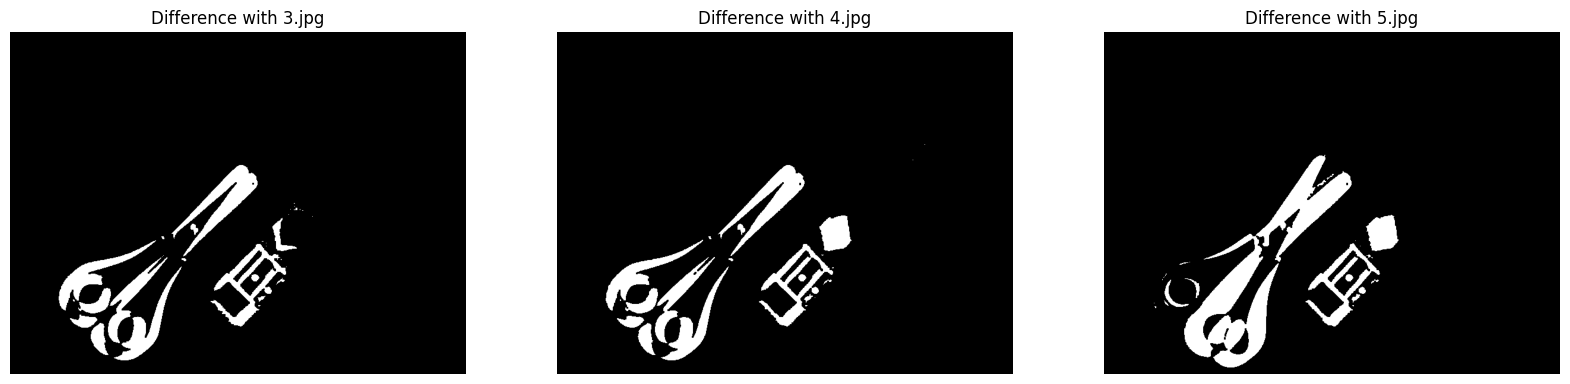

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def process_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    _, thresh = cv2.threshold(gray, 40, 255, cv2.THRESH_BINARY)

    kernel = np.ones((3,3), np.uint8)
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    return morph

ref_image = cv2.imread('1.jpg')

results = []

for i in [3, 4, 5]:
    comp_image = cv2.imread(f'{i}.jpg')

    diff = cv2.absdiff(ref_image, comp_image)

    processed_diff = process_image(diff)

    results.append(processed_diff)

fig, axes = plt.subplots(1, 3, figsize=(20, 10))
for ax, img, title in zip(axes, results, ['Difference with 3.jpg', 'Difference with 4.jpg', 'Difference with 5.jpg']):
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title(title)
    ax.axis('off')
    
plt.show()


### Wnioski

- Na każdym ze zdjęć możemy zauważyć zmienioną lekko pozycję nożyczek oraz ich rozstawu
- Możemy również zaobserwować obrócenie strugawki
- Na zdjęciu nr. 4 oraz 5 obserwujemy różnice w postaci zniknięcia małej kostki nad strugawką
- Na zdjęciu nr. 1 możemy zaobserwować przesunięcie tej kostki

## Zadanie 2 - Detekcja zmian w obrazie (dzielenie obrzów)

Dzielienie jest kolejną opreacją, którą można wykorzystać w celu detekcji zmian w obrazie.  
  
Do wykonania tego zadania również proszę wykorzystać zdjęcia zamieszczone na e-portalu. Należy sprawdzić, czy przedmioty na zdjęciach 3.jpg, 4.jpg, 5.jpg uległy zmianie lub przesunięciu względem zdjecia 1.jpg z wkorzystaniem ilorazu zdjęć. Proszę pamięteć, że najlepszy efekt uzyskamu stosując dodatkowe operacje poprawiające efekt odejmowania: opercje morfologiczne, progowanie.

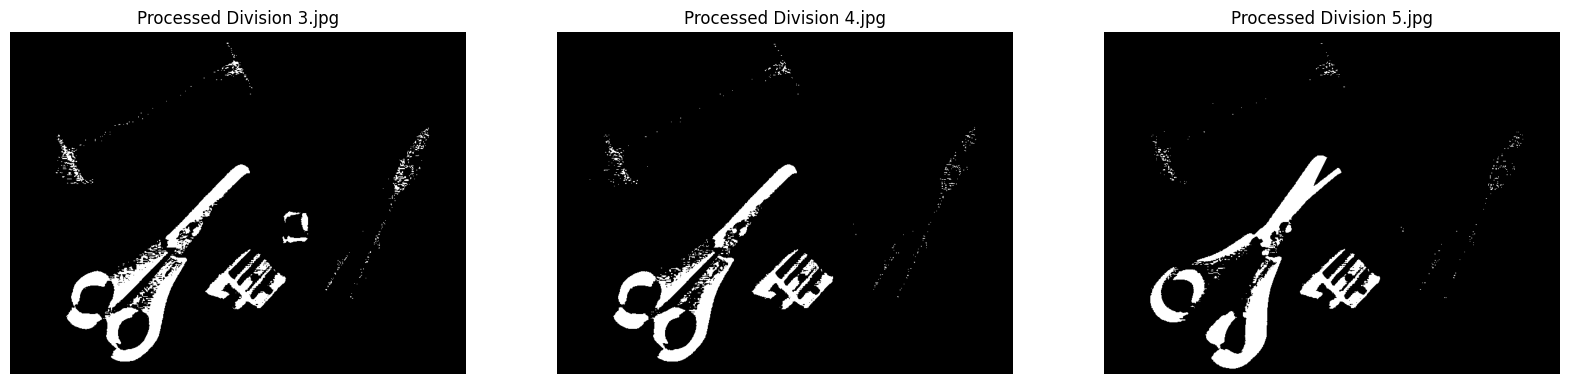

In [72]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def divide_images(img1, img2):
    img1_float = img1.astype(float)
    img2_float = img2.astype(float)
    result = cv2.divide(img1_float, img2_float)
    return result

def process_divided_image(image):
    _, thresh = cv2.threshold(image, 1, 255, cv2.THRESH_BINARY)

    kernel = np.ones((1, 1), np.uint8)
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    return morph

ref_image = cv2.imread('1.jpg', cv2.IMREAD_GRAYSCALE)

divided_images = []

for i in [3, 4, 5]:
    comp_image = cv2.imread(f'{i}.jpg', cv2.IMREAD_GRAYSCALE)
    div_result = divide_images(ref_image, comp_image)
    divided_images.append(div_result)

processed_images_no_epsilon = [process_divided_image(img) for img in divided_images]

fig, axes = plt.subplots(1, len(processed_images_no_epsilon), figsize=(20, 5))
for ax, img, title in zip(axes, processed_images_no_epsilon, ['Processed Division with 3.jpg', 'Processed Division with 4.jpg', 'Processed Division with 5.jpg']):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.axis('off')
plt.show()



## Zadanie 3 - detekcja ruchu

Techniki wykrywania zmian w obrazach możemy łatwo zastosować do stumienia wideo i zbudować detektor ruchu. W tym celu wczytujemy pierwszą ramkę wideo jako ramka referencyjna, a następnie wykonujemy operację odejmowania lub dzielenia ramki referencyjnej przez kolejne. Ogólny schemat można zapisać:


1.   wczytaj wideo 
2.   zamień ramkę na obraz monochromatyczny 
3. zastosuj filtr wygładzający (np. Gaussowaski)
4. dla kolejnej rami powtórz kroki 2 i 3 
5. Odejmij drugą ramkę od pierwszej 
6. zapisz drugą ramkę jako referencyjną 
7. do wynku odejmowania zastosuj operacje morfologiczne i progowanie
8. z obrazu wynikowego wylicz kontury
9. na podstawie konturów oblicz prostokąt okalający (bounding box)
10. nanieś prostokąt na oryginalne wideo.
11. wyświetl wynik


In [80]:
import cv2

video_path = 'lab_7.webm'
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

while True:
    ret, frame = cap.read()
    
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    cv2.imshow('Video', gray)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


### Detekcja ruchu z kamery
 
Państwa zadaniem jest napisanie prostej aplikacji, która będzie przetwarzać obraz z kamery komputera i poinformuje użytkownika jeśli w obrazie z kamery zostanie wykrytu ruch. Należy wyświetlić stosowny komunikat w konsoli oraz na podglądzie z kamery. 